# Sparkify Churn Modelling Project with Pyspark on IBM Cloud / Part 1 - Explaratory Data Analysis


In this project we will try to forecast churn users for music app Sparkify. We will use Spark Hadoop platform on IBM Cloud Pak Analytics Engine platform since data is huge.

We will discover data and make some feature engineerings firstly. Then we will implement some classification algorithms to predict churn users.

Since churn users are less amount of data ( 23% almost), we will compare algorithms with F1 measure of class 1-churn. 

We will make some hyperparameter search to achieve better predictions score after deciding algorithm.

At the end, we will have a solid machine learning model that predicts which users are more likely to churn based on behaviour and usage data we have.

In [2]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-1cdcd4b5-3a8d-4a73-8bc8-105aa315ceb5',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'jzGPp7oq2-tV7BIJwyEl1bYN2zlA1b2XC32iD3MwWkcO'
}

configuration_name = 'os_8c4f40c89046482b8c6a3e456ce2c877_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-cr5wlxaiypcbhb'))
df.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [3]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
df

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.count()

543705

In [7]:
df = df.dropna(how='any', subset=['userId', 'sessionId'])
df.count()

543705

It seems like there is no null value for userId and sessionId.
Let's check these columns:

In [8]:
df.select('userId').dropDuplicates().sort('userId').show(10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



Some user id's are equal to a "space" character, so we filter and check this data below:

In [9]:
df.filter(df.userId == "").show(3)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          186|    null|  null| paid|    null|   GET|Home|        null|      178|null|   200|1538352148000|     null|      |
|  null|Logged Out|     null|  null|          187|    null|  null| paid|    null|   GET|Home|        null|      178|null|   200|1538352151000|     null|      |
|  null|Logged Out|     null|  null|          188|    null|  null| paid|    null|   GET|Home|        null|      178|null|   200|1538352168000|     null|      |
+------+----------+---------+------+----

In [10]:
df.filter(df["sessionId"]=="").show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



We have some space characters for user id column, we will delete them from the data.

In [11]:
df = df.filter(df["userId"] != "")
df.count()

528005

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Let's check how many page action type we have:

In [12]:
df.select("page").dropDuplicates().sort('page').show(25)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



### Time Conversion

In [13]:
#udf to convert the ts to timestamp
get_timestamp = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

#apply this udf in the dataframe with your timestamp
df = df.withColumn("datetime", get_timestamp(df.ts))

#drop the ts column
df = df.drop("ts")

df.show(1)

+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+--------------------+------+-------------------+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|    page| registration|sessionId|         song|status|           userAgent|userId|           datetime|
+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+--------------------+------+-------------------+
|Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|Grand Designs|   200|"Mozilla/5.0 (Mac...|   293|2018-10-01 00:00:11|
+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------

### Define Churn

In [14]:
churn_users = df.filter(df.page == "Cancellation Confirmation").select("userId").dropDuplicates().collect()
churn_user_list =  [str(row.userId) for row in churn_users]
churn_user_list

['296',
 '100010',
 '200002',
 '124',
 '51',
 '200037',
 '54',
 '234',
 '154',
 '132',
 '100014',
 '200',
 '11',
 '34',
 '162',
 '200013',
 '28',
 '85',
 '16',
 '187',
 '188',
 '223',
 '100025',
 '100040',
 '214',
 '221',
 '18',
 '100005',
 '61',
 '200039',
 '131',
 '126',
 '140',
 '120',
 '200027',
 '100047',
 '130',
 '300004',
 '164',
 '208',
 '89',
 '198',
 '118',
 '100041',
 '200050',
 '246',
 '100004',
 '41',
 '200024',
 '100042',
 '200008',
 '100016',
 '100003',
 '167',
 '100036',
 '271',
 '189',
 '156',
 '288',
 '100024',
 '100038',
 '100051',
 '200023',
 '231',
 '293',
 '100011',
 '81',
 '100044',
 '100012',
 '200016',
 '200020',
 '100045',
 '100043',
 '200028',
 '236',
 '32',
 '88',
 '100032',
 '100023',
 '100013',
 '10',
 '100049',
 '300047',
 '172',
 '100017',
 '200041',
 '100030',
 '265',
 '39',
 '123',
 '13',
 '100048',
 '196',
 '200045',
 '100018',
 '100028',
 '45',
 '200021',
 '100001']

In [15]:
from pyspark.sql.functions import *

We create a churn column and set it as 1 if user has a session that contains "cancellation confirmation" page type.

We used the list that we created above as churn_user_list to assign churn label.

In [16]:
df = df.withColumn("churn", when(col('userId').isin(churn_user_list), 1).otherwise(0))

Check and see it's working below:

In [17]:
df.filter(df.userId == "125").select(["userId","sessionId","page","churn"]).show(40)

+------+---------+-----------+-----+
|userId|sessionId|       page|churn|
+------+---------+-----------+-----+
|   125|      334|       Home|    0|
|   125|      334| Add Friend|    0|
|   125|      334|   Settings|    0|
|   125|      334|   NextSong|    0|
|   125|      334|   NextSong|    0|
|   125|      334|   NextSong|    0|
|   125|      334|   NextSong|    0|
|   125|      334|  Thumbs Up|    0|
|   125|      334|   NextSong|    0|
|   125|      647|   NextSong|    0|
|   125|      647|Roll Advert|    0|
|   125|      647|   NextSong|    0|
|   125|      647|   NextSong|    0|
|   125|      647|   NextSong|    0|
|   125|      647|   NextSong|    0|
|   125|      647|   NextSong|    0|
|   125|      647|Roll Advert|    0|
|   125|      647|   NextSong|    0|
|   125|      647|   NextSong|    0|
|   125|      647|Roll Advert|    0|
|   125|      647|   NextSong|    0|
|   125|      647|   NextSong|    0|
|   125|      647|  Thumbs Up|    0|
|   125|      647|   NextSong|    0|
|

In [18]:
df.filter(df.userId == "76").select(["userId","sessionId","page","churn","datetime"]).orderBy(desc("datetime")).show(15)

+------+---------+---------------+-----+-------------------+
|userId|sessionId|           page|churn|           datetime|
+------+---------+---------------+-----+-------------------+
|    76|     3641|       NextSong|    0|2018-11-29 15:34:42|
|    76|     3641|       NextSong|    0|2018-11-29 15:33:04|
|    76|     3641|       NextSong|    0|2018-11-29 15:29:03|
|    76|     3641|       NextSong|    0|2018-11-29 15:24:08|
|    76|     3641|       NextSong|    0|2018-11-29 15:19:34|
|    76|     3641|       NextSong|    0|2018-11-29 15:12:24|
|    76|     3641|       NextSong|    0|2018-11-29 15:08:39|
|    76|     3641|      Thumbs Up|    0|2018-11-29 15:03:33|
|    76|     3641|       NextSong|    0|2018-11-29 15:03:32|
|    76|     3641|Add to Playlist|    0|2018-11-29 14:33:31|
|    76|     3641|      Thumbs Up|    0|2018-11-29 13:26:18|
|    76|     3641|       NextSong|    0|2018-11-29 13:26:17|
|    76|     3641|       NextSong|    0|2018-11-29 13:22:16|
|    76|     3641|      

#### Analyze some user history session data to grasp idea about why user churn
#### Check some random user_id session history with needed columns below:

In [19]:
df.select(["userId","page","song","sessionId","artist","datetime","level"]).where(df.userId == "100011").sort("datetime").show(50)

+------+-----------+--------------------+---------+--------------------+-------------------+-----+
|userId|       page|                song|sessionId|              artist|           datetime|level|
+------+-----------+--------------------+---------+--------------------+-------------------+-----+
|100011|       Home|                null|       69|                null|2018-10-01 16:45:01| free|
|100011| Add Friend|                null|       69|                null|2018-10-01 16:45:02| free|
|100011|   NextSong|      Asche Zu Asche|       69|           Rammstein|2018-10-01 16:45:05| free|
|100011|Roll Advert|                null|       69|                null|2018-10-01 16:45:13| free|
|100011|   NextSong|      Lady Marmalade|       69|Christina Aguiler...|2018-10-01 16:48:56| free|
|100011| Add Friend|                null|       69|                null|2018-10-01 16:48:57| free|
|100011|   NextSong|Lay Your Hands On Me|       69|            Bon Jovi|2018-10-01 16:53:20| free|
|100011|  

In [20]:
df.select(["userId","page","song","sessionId","artist","datetime","level"]).where(df.userId == "100002").sort("datetime").show(300)

+------+----------------+--------------------+---------+--------------------+-------------------+-----+
|userId|            page|                song|sessionId|              artist|           datetime|level|
+------+----------------+--------------------+---------+--------------------+-------------------+-----+
|100002|            Home|                null|       70|                null|2018-10-09 19:28:59| free|
|100002|        NextSong| Secretly Minnesotan|       70|          Tullycraft|2018-10-09 19:29:15| free|
|100002|     Roll Advert|                null|       70|                null|2018-10-09 19:29:59| free|
|100002|        NextSong|The Wolf Is Loose...|       70|            Mastodon|2018-10-09 19:33:36| free|
|100002|        NextSong|I Was Made For Lo...|       70|                Kiss|2018-10-09 19:37:11| free|
|100002| Add to Playlist|                null|       70|                null|2018-10-09 19:37:27| free|
|100002|        NextSong|Well Water Black ...|       70|        

In [21]:
df.select(["userId","page","song","sessionId","artist","datetime","level"]).where(df.userId == "100004").sort("datetime").show(10000)

+------+--------------------+--------------------+---------+--------------------+-------------------+-----+
|userId|                page|                song|sessionId|              artist|           datetime|level|
+------+--------------------+--------------------+---------+--------------------+-------------------+-----+
|100004|                Home|                null|        4|                null|2018-10-03 02:47:15| free|
|100004|          Add Friend|                null|        4|                null|2018-10-03 02:47:16| free|
|100004|            NextSong|Sweet Thing (Live...|        4|Rufus And Chaka Khan|2018-10-03 02:49:14| free|
|100004|         Roll Advert|                null|        4|                null|2018-10-03 02:51:55| free|
|100004|            NextSong|             My Life|        4|              Chanel|2018-10-03 02:52:42| free|
|100004|           Thumbs Up|                null|        4|                null|2018-10-03 02:52:43| free|
|100004|            NextSong

In [22]:
df.select(["userId","page","song","sessionId","artist","datetime","level"]).where(df.userId == "100005").sort("datetime").show(10000)

+------+--------------------+--------------------+---------+--------------------+-------------------+-----+
|userId|                page|                song|sessionId|              artist|           datetime|level|
+------+--------------------+--------------------+---------+--------------------+-------------------+-----+
|100005|                Home|                null|        5|                null|2018-10-01 15:16:55| free|
|100005|            NextSong|   It Was A Good Day|        5|            Ice Cube|2018-10-01 15:17:00| free|
|100005|            NextSong|         Sarah Maria|        5|        James Taylor|2018-10-01 15:21:12| free|
|100005|            NextSong| Take A Chance On Us|        5|  Scouting for Girls|2018-10-01 15:23:56| free|
|100005|         Roll Advert|                null|        5|                null|2018-10-01 15:23:59| free|
|100005|            NextSong| Love Is Not A Fight|        5|     Warren Barfield|2018-10-01 15:29:15| free|
|100005|            NextSong

In [23]:
df.select(["userId","page","song","sessionId","artist","datetime","level"]).where(df.userId == "100011").sort("datetime").show(10000)

+------+--------------------+--------------------+---------+--------------------+-------------------+-----+
|userId|                page|                song|sessionId|              artist|           datetime|level|
+------+--------------------+--------------------+---------+--------------------+-------------------+-----+
|100011|                Home|                null|       69|                null|2018-10-01 16:45:01| free|
|100011|          Add Friend|                null|       69|                null|2018-10-01 16:45:02| free|
|100011|            NextSong|      Asche Zu Asche|       69|           Rammstein|2018-10-01 16:45:05| free|
|100011|         Roll Advert|                null|       69|                null|2018-10-01 16:45:13| free|
|100011|            NextSong|      Lady Marmalade|       69|Christina Aguiler...|2018-10-01 16:48:56| free|
|100011|          Add Friend|                null|       69|                null|2018-10-01 16:48:57| free|
|100011|            NextSong

In [24]:
df.select(["userId","page","song","sessionId","artist","datetime","level"]).where(df.userId == "100025").sort("datetime").show(10000)

+------+--------------------+--------------------+---------+--------------------+-------------------+-----+
|userId|                page|                song|sessionId|              artist|           datetime|level|
+------+--------------------+--------------------+---------+--------------------+-------------------+-----+
|100025|            NextSong|            Marry Me|       25|               Train|2018-10-01 12:36:57| paid|
|100025|            NextSong|          El Fracaso|       25|         Hiperboreal|2018-10-01 12:40:22| paid|
|100025|                Home|                null|       25|                null|2018-10-01 12:42:25| paid|
|100025|            NextSong|    Hey_ Soul Sister|       25|               Train|2018-10-01 12:43:43| paid|
|100025|     Add to Playlist|                null|       25|                null|2018-10-01 12:50:43| paid|
|100025|            NextSong|          Who We Are|       25|           Lifehouse|2018-10-01 12:55:16| paid|
|100025|           Thumbs Up

In [25]:
df.select(["page","song","sessionId","artist","datetime","level"]).where(df.userId == "100015").sort("datetime").show(10000)

+---------------+--------------------+---------+--------------------+-------------------+-----+
|           page|                song|sessionId|              artist|           datetime|level|
+---------------+--------------------+---------+--------------------+-------------------+-----+
|       NextSong|Willows On The Water|       15|                Enya|2018-10-01 21:42:39| free|
|       NextSong|                Caer|       15|      Mikel Erentxun|2018-10-01 21:45:40| free|
|Add to Playlist|                null|       15|                null|2018-10-01 21:48:44| free|
|       NextSong|The Most Beautifu...|       15|Flight Of The Con...|2018-10-01 21:48:50| free|
|       NextSong|           Lazy Days|       15|                Enya|2018-10-01 21:52:52| free|
|      Thumbs Up|                null|       15|                null|2018-10-01 21:52:53| free|
|       NextSong|          Danza Rota|       15|         Soda Stereo|2018-10-01 21:56:35| free|
|Add to Playlist|                null|  

In [26]:
df.select(["page","song","sessionId","artist","datetime","level"]).where(df.userId == "100014").sort("datetime").show(10000)

+--------------------+--------------------+---------+--------------------+-------------------+-----+
|                page|                song|sessionId|              artist|           datetime|level|
+--------------------+--------------------+---------+--------------------+-------------------+-----+
|            NextSong|Bleed It Out [Liv...|       76|         Linkin Park|2018-10-03 10:16:57| paid|
|            NextSong|     End of the Road|       76|     Umphrey's McGee|2018-10-03 10:25:11| paid|
|            NextSong|        No Damn Fool|       76|         Throttlerod|2018-10-03 10:28:27| paid|
|     Add to Playlist|                null|       76|                null|2018-10-03 10:30:38| paid|
|            NextSong|        Frankenstein|       76|  The New York Dolls|2018-10-03 10:31:48| paid|
|            NextSong|     Sleight Of Hand|       76|           Pearl Jam|2018-10-03 10:37:46| paid|
|            NextSong|Opening Up (Ce So...|       76|             Chromeo|2018-10-03 10:42:

## Feature Analysis

Let's check the features we have first.

In [27]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- churn: integer (nullable = false)



### 1. Artist feature

In [31]:
df_count_artist = df.filter(df.page == "NextSong").groupby(["userId","churn"]).agg(count("artist"),countDistinct("artist").alias("distinct_artist"))
df_count_artist.show(5)

+------+-----+-------------+---------------+
|userId|churn|count(artist)|distinct_artist|
+------+-----+-------------+---------------+
|    73|    0|          240|            215|
|    19|    0|           51|             50|
|   209|    0|         1499|           1055|
|200007|    0|          140|            136|
|100030|    1|           98|             96|
+------+-----+-------------+---------------+
only showing top 5 rows



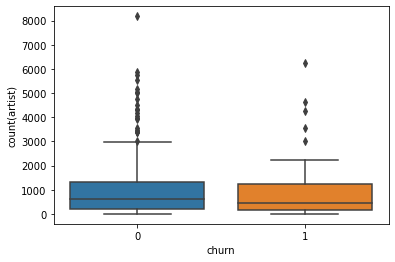

In [32]:
ax = sns.boxplot(x="churn", y="count(artist)", data=df_count_artist.toPandas())

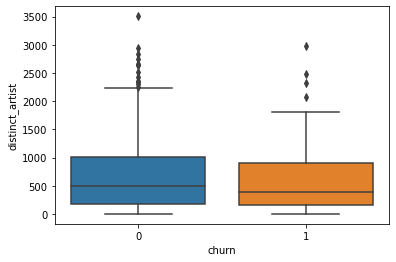

In [33]:
ax = sns.boxplot(x="churn", y="distinct_artist", data=df_count_artist.toPandas())

In [34]:
df_artist_mean = df_count_artist.groupby("churn").agg({"count(artist)":"mean","distinct_artist":"mean"})
df_artist_mean.show(5)

+-----+------------------+--------------------+
|churn|avg(count(artist))|avg(distinct_artist)|
+-----+------------------+--------------------+
|    1| 852.1111111111111|   592.7373737373738|
|    0| 998.6189111747851|   677.7707736389685|
+-----+------------------+--------------------+



We can say that churn users tend to listen less artists comparing to non-churn users.

### 2. Auth feature

In [35]:
df.toPandas().auth.value_counts()

Logged In    527906
Cancelled        99
Name: auth, dtype: int64

This feature seems to not-giving any meaningful data for us. We can drop it.

In [36]:
df =df.drop("auth")

In [37]:
df.show(1)

+-------------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+--------------------+------+-------------------+-----+
|       artist|firstName|gender|itemInSession|lastName|   length|level|          location|method|    page| registration|sessionId|         song|status|           userAgent|userId|           datetime|churn|
+-------------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+--------------------+------+-------------------+-----+
|Martin Orford|   Joseph|     M|           20| Morales|597.55057| free|Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|Grand Designs|   200|"Mozilla/5.0 (Mac...|   293|2018-10-01 00:00:11|    1|
+-------------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+--------------------+----

### 3. First Name and Last Name Features

In [54]:
from pyspark.sql.functions import countDistinct
df.groupby("firstName").agg(countDistinct("userId").alias("distinct_userId")).sort('distinct_userId', ascending=False).show(10)

+-----------+---------------+
|  firstName|distinct_userId|
+-----------+---------------+
|     Joseph|              7|
|     Samuel|              6|
|      James|              6|
|Christopher|              5|
|    Lillian|              4|
|   Isabella|              4|
|     Oliver|              4|
|     Jayden|              4|
|     Sophia|              4|
|     Bryson|              3|
+-----------+---------------+
only showing top 10 rows



In [55]:
df.groupby("lastName").agg(countDistinct("userId").alias("distinct_userId")).sort('distinct_userId', ascending=False).show(10)

+--------+---------------+
|lastName|distinct_userId|
+--------+---------------+
|Williams|             12|
| Johnson|             10|
|   Smith|              9|
|   Jones|              8|
|    Cook|              7|
| Stewart|              6|
|  Garcia|              5|
|Robinson|              5|
|   White|              5|
|Thompson|              5|
+--------+---------------+
only showing top 10 rows



If we have nationality, origin other demographic features , we may use them maybe. But name feature is very unique and useless for churn analysis.

We can drop name and last name features.

In [56]:
df = df.select([c for c in df.columns if c not in {'firstName','lastName'}])

### 4. Gender Feature

If a user is a churn user, user's mean churn column will be 1 since all rows have value of 1.

It is same for non-churn users, it will be 0 for mean value, since all the sessions have the same churn value as 0.

In [57]:
df_gender = df.groupby(["gender","userId"]).agg({"churn":"mean"})
df_gender.show(10)

+------+------+----------+
|gender|userId|avg(churn)|
+------+------+----------+
|     F|100008|       0.0|
|     F|   222|       0.0|
|     M|100049|       1.0|
|     F|200040|       0.0|
|     F|   209|       0.0|
|     M|    38|       0.0|
|     F|   181|       0.0|
|     F|100037|       0.0|
|     F|   267|       0.0|
|     F|200021|       1.0|
+------+------+----------+
only showing top 10 rows



We will make a gender groupby and get mean value of avg(churn) column. It will give us churn user rate for selected gender.

Male users seems to more inclined to churn comparing to Female users according the data below.

In [58]:
df_gender_churn_rate = df_gender.groupby("gender").agg({"avg(churn)":"mean"})
df_gender_churn_rate.show(5)

+------+-------------------+
|gender|    avg(avg(churn))|
+------+-------------------+
|     F|0.22727272727272727|
|     M|              0.216|
+------+-------------------+



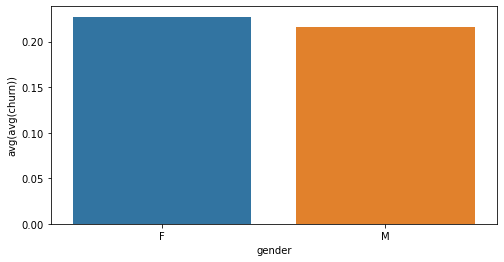

In [59]:
fig = plt.figure(figsize=(8, 4))
sns.barplot(x="gender", y="avg(avg(churn))", data=df_gender_churn_rate.toPandas())

### 5. itemInSession feature

We see that itemInSession is a session action number per Session. It starts at 1 and get values incrementally.

Since it does not give any insight about churn, we may drop it.

In [60]:
df.filter(df.userId == "111").select(["userId","itemInSession","sessionId","datetime","page","song","churn"]).show(45)

+------+-------------+---------+-------------------+---------------+--------------------+-----+
|userId|itemInSession|sessionId|           datetime|           page|                song|churn|
+------+-------------+---------+-------------------+---------------+--------------------+-----+
|   111|            0|      110|2018-10-04 14:25:31|       NextSong|        Jernskjorten|    0|
|   111|            1|      110|2018-10-04 14:29:43|       NextSong|Ein Elefant FÃÂ¼...|    0|
|   111|            2|      110|2018-10-04 14:31:47|           Home|                null|    0|
|   111|            3|      110|2018-10-04 14:31:48|     Add Friend|                null|    0|
|   111|            4|      110|2018-10-04 14:31:49|     Add Friend|                null|    0|
|   111|            5|      110|2018-10-04 14:34:25|       NextSong|Harder Better Fas...|    0|
|   111|            6|      110|2018-10-04 14:38:08|       NextSong|You Are The Sunsh...|    0|
|   111|            7|      110|2018-10-

In [61]:
df =df.drop("itemInSession")

### 6. Length Feature

It shows duration of a song. We may analyze average listening duration and see whether there is a correlation with churn.

Master of Puppets is a well-known Metallica song and its duration 8 minutes and 36 seconds. 

This data below tells us its length 515 , we may say length feature shows song duration on seconds basis.

In [62]:
df.filter(df.userId == "101").select(["userId","length","sessionId","datetime","page","song","churn"]).show(45)

+------+---------+---------+-------------------+---------------+--------------------+-----+
|userId|   length|sessionId|           datetime|           page|                song|churn|
+------+---------+---------+-------------------+---------------+--------------------+-----+
|   101|     null|      100|2018-10-01 01:52:02|           Home|                null|    0|
|   101|491.38893|      100|2018-10-01 01:54:38|       NextSong|Schwarze Biene (B...|    0|
|   101| 29.98812|      100|2018-10-01 02:02:49|       NextSong|           That Case|    0|
|   101|     null|      100|2018-10-01 02:02:50|      Thumbs Up|                null|    0|
|   101|197.53751|      100|2018-10-01 02:03:18|       NextSong|      Paperthin Hymn|    0|
|   101|300.53832|      100|2018-10-01 02:06:35|       NextSong|Mean Street (Albu...|    0|
|   101|     null|      100|2018-10-01 02:13:43|           Home|                null|    0|
|   101|147.69587|      100|2018-10-01 02:17:41|       NextSong|El Corrido De Ju

We sum duration lengths for every user and get total user song play length.

In [63]:
df_length_user = df.filter(df.page=="NextSong").groupby(["churn","userId"]).agg({"length":"sum"})
df_length_user.show(10)

+-----+------+------------------+
|churn|userId|       sum(length)|
+-----+------+------------------+
|    0|   114|377026.49672000075|
|    0|   263|205754.34674999994|
|    0|   185| 648953.5565299987|
|    0|200012|       11298.67202|
|    1|   124|      456664.04058|
|    0|   160| 271487.9099699999|
|    0|300007|184386.53294999996|
|    0|    82|288002.42079999973|
|    0|    14|20054.742969999996|
|    1|200027| 86043.73950999997|
+-----+------+------------------+
only showing top 10 rows



In [64]:
df_length_user_rate = df_length_user.groupby("churn").agg({"sum(length)":"mean"})
df_length_user_rate.show(5)

+-----+------------------+
|churn|  avg(sum(length))|
+-----+------------------+
|    1|212170.54003050504|
|    0|248241.54574739255|
+-----+------------------+



We get an average sum duration per user and see that churn users tent to play songs lesser than non-churners.

Average total song duration is 212170 seconds for churn users.

Average total song duration is 248241 seconds for non-churn users.

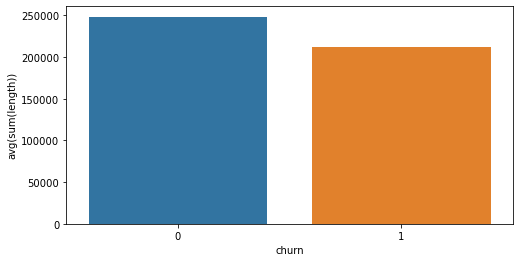

In [65]:
fig = plt.figure(figsize=(8, 4))
sns.barplot(x="churn", y="avg(sum(length))", data=df_length_user_rate.toPandas())

### 7. Level Feature

We can see from data below that a user's level can change with time.

A user can make an upgrade and can turn to paid level from free account.

We will get the last value before churn.

In [66]:
df_level_user = df.groupby(["userId","churn"]).agg({"level":"last"})
df_level_user.show(10)

+------+-----+-----------+
|userId|churn|last(level)|
+------+-----+-----------+
|    19|    0|       free|
|    73|    0|       free|
|100005|    1|       free|
|100030|    1|       paid|
|100034|    0|       paid|
|200007|    0|       free|
|   209|    0|       paid|
|   184|    0|       paid|
|100048|    1|       paid|
|    50|    0|       free|
+------+-----+-----------+
only showing top 10 rows



Let's check our data for userId 105, it seems paid in our new table. 

In [67]:
df_level_user.filter(df_level_user.userId == "105").show(10)

+------+-----+-----------+
|userId|churn|last(level)|
+------+-----+-----------+
|   105|    0|       paid|
+------+-----+-----------+



Yes, it was free before. Then it changed to paid statu. We may accept that user as paid user according to it's last state.

In [68]:
df.filter(df.userId == "105").select(["userId","length","level","datetime","page","song","churn"]).show(45)

+------+----------+-----+-------------------+---------------+--------------------+-----+
|userId|    length|level|           datetime|           page|                song|churn|
+------+----------+-----+-------------------+---------------+--------------------+-----+
|   105|      null| free|2018-10-02 20:08:38|           Home|                null|    0|
|   105| 201.45587| free|2018-10-02 20:10:00|       NextSong|Hiding All The Stars|    0|
|   105| 134.47791| free|2018-10-02 20:13:21|       NextSong|          Fuck Kitty|    0|
|   105| 295.67955| free|2018-10-02 20:15:35|       NextSong|Pursuit Of Happin...|    0|
|   105| 258.32444| free|2018-10-02 20:20:30|       NextSong|     Take Me As I Am|    0|
|   105| 211.12118| free|2018-10-02 20:24:48|       NextSong|Billionaire [feat...|    0|
|   105| 303.20281| free|2018-10-02 20:28:19|       NextSong|     Round And Round|    0|
|   105| 200.64608| free|2018-10-02 20:33:22|       NextSong|  These Are The Days|    0|
|   105|      null| f

In [69]:
df_level_churn_rate = df_level_user.groupby("last(level)").agg({"churn":"mean"})
df_level_churn_rate.show(5)

+-----------+-------------------+
|last(level)|         avg(churn)|
+-----------+-------------------+
|       free|0.17415730337078653|
|       paid| 0.2518518518518518|
+-----------+-------------------+



It seems that we have 0.17 % churn rate for free users.

Paid users's churn rate is 0.25 , it is higher than free users.

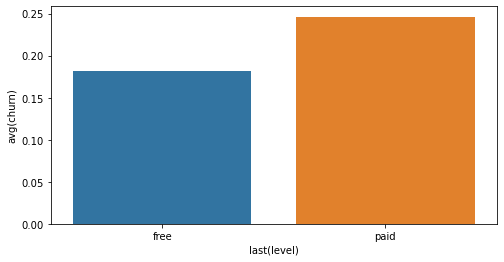

In [70]:
fig = plt.figure(figsize=(8, 4))
sns.barplot(x="last(level)", y="avg(churn)", data=df_level_churn_rate.toPandas())

### 8. Location Feature

In [71]:
df_location_user = df.groupby(["location","userId"]).agg({"churn":"mean"})
df_location_user.show(10)

+--------------------+------+----------+
|            location|userId|avg(churn)|
+--------------------+------+----------+
|Miami-Fort Lauder...|    20|       0.0|
|          Fresno, CA|300049|       0.0|
|New York-Newark-J...|   158|       0.0|
|Dallas-Fort Worth...|300010|       0.0|
|       Fairbanks, AK|   128|       0.0|
|Cincinnati, OH-KY-IN|    68|       0.0|
|Chicago-Napervill...|100020|       0.0|
|Dallas-Fort Worth...|200050|       1.0|
|McAllen-Edinburg-...|    78|       0.0|
|New York-Newark-J...|100014|       1.0|
+--------------------+------+----------+
only showing top 10 rows



In [72]:
df_location_churn_rate = df_location_user.groupby("location").agg({"avg(churn)":"mean"})
df_location_churn_rate.show(5)

+--------------------+---------------+
|            location|avg(avg(churn))|
+--------------------+---------------+
|     Gainesville, FL|            0.0|
|Atlantic City-Ham...|            0.0|
|        Richmond, VA|            0.0|
|          Tucson, AZ|            0.0|
|       Oskaloosa, IA|            0.0|
+--------------------+---------------+
only showing top 5 rows



We have 1 user from Cleveland-Elyria, OH and he/she churned, we can see same value below:

In [73]:
df.filter(df.location=="Cleveland-Elyria, OH").groupby(["userId","location"]).agg({"churn":"mean"}).show(10)

+------+--------------------+----------+
|userId|            location|avg(churn)|
+------+--------------------+----------+
|100013|Cleveland-Elyria, OH|       1.0|
+------+--------------------+----------+



We see some variation between locations. We may create a new state feature from this location knowledge.

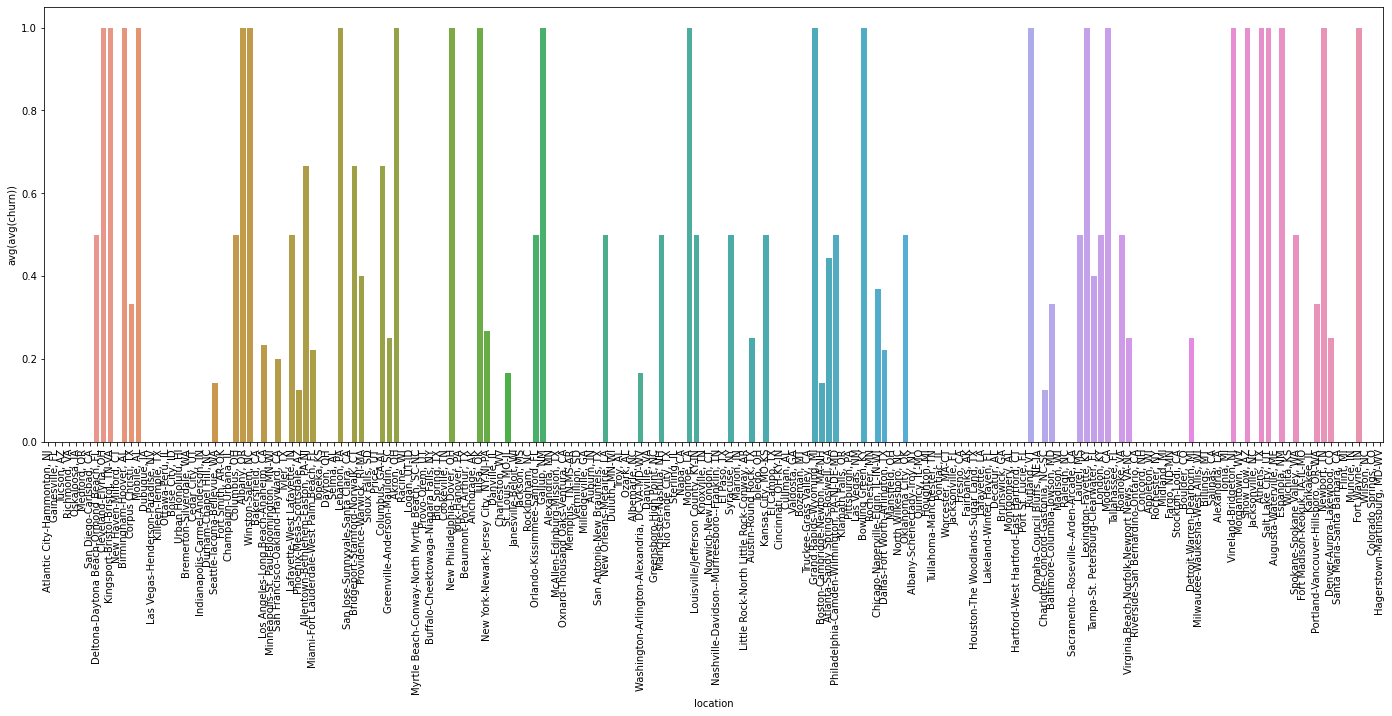

In [74]:
fig = plt.figure(figsize=(24, 8))
sns.barplot(x="location", y="avg(avg(churn))", data=df_location_churn_rate.toPandas())
plt.xticks(rotation=90)
plt.show()

### 9. Method Feature

In [75]:
df.toPandas().method.value_counts()

PUT    489128
GET     38877
Name: method, dtype: int64

Since it is a https internet procotal type that shows what the interaction method is, we may drop this feature.

In [76]:
df = df.drop("method")

### 10. Registration Feature

This is a timestamp of user registration. We can conver it to a datetime feature.

In [77]:
df.filter(df.userId == "25").select(["userId","registration","level","datetime","page","song","churn"]).show(10)

+------+-------------+-----+-------------------+--------+--------------------+-----+
|userId| registration|level|           datetime|    page|                song|churn|
+------+-------------+-----+-------------------+--------+--------------------+-----+
|    25|1536287099000| free|2018-10-01 17:34:21|NextSong|     Work (Explicit)|    0|
|    25|1536287099000| free|2018-10-01 17:37:18|NextSong|          I'm Comin'|    0|
|    25|1536287099000| free|2018-10-01 17:41:12|NextSong|Out of Key_ But i...|    0|
|    25|1536287099000| free|2018-10-01 17:45:42|NextSong|The Strength To G...|    0|
|    25|1536287099000| free|2018-10-01 17:49:09|NextSong|              Pepper|    0|
|    25|1536287099000| free|2018-10-01 17:54:06|NextSong|Can't Hide From Y...|    0|
|    25|1536287099000| free|2018-10-01 17:58:54|NextSong|            Les mots|    0|
|    25|1536287099000| free|2018-10-02 09:25:05|NextSong|         Cold As You|    0|
|    25|1536287099000| free|2018-10-02 09:29:15|NextSong|        

In [78]:
#udf to convert the registration to timestamp
get_timestamp = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

#apply this udf in the dataframe with your timestamp
df = df.withColumn("register-datetime", get_timestamp(df.registration))

#drop the ts column
df = df.drop("registration")

In [79]:
df.filter(df.userId == "25").select(["userId","register-datetime","level","datetime","page","song","churn"]).show(10)

+------+-------------------+-----+-------------------+--------+--------------------+-----+
|userId|  register-datetime|level|           datetime|    page|                song|churn|
+------+-------------------+-----+-------------------+--------+--------------------+-----+
|    25|2018-09-07 02:24:59| free|2018-10-01 17:34:21|NextSong|     Work (Explicit)|    0|
|    25|2018-09-07 02:24:59| free|2018-10-01 17:37:18|NextSong|          I'm Comin'|    0|
|    25|2018-09-07 02:24:59| free|2018-10-01 17:41:12|NextSong|Out of Key_ But i...|    0|
|    25|2018-09-07 02:24:59| free|2018-10-01 17:45:42|NextSong|The Strength To G...|    0|
|    25|2018-09-07 02:24:59| free|2018-10-01 17:49:09|NextSong|              Pepper|    0|
|    25|2018-09-07 02:24:59| free|2018-10-01 17:54:06|NextSong|Can't Hide From Y...|    0|
|    25|2018-09-07 02:24:59| free|2018-10-01 17:58:54|NextSong|            Les mots|    0|
|    25|2018-09-07 02:24:59| free|2018-10-02 09:25:05|NextSong|         Cold As You|    0|

In [80]:
df.select('register-datetime').describe().show()

+-------+-------------------+
|summary|  register-datetime|
+-------+-------------------+
|  count|             528005|
|   mean|               null|
| stddev|               null|
|    min|2017-11-05 03:56:33|
|    max|2018-11-24 15:37:54|
+-------+-------------------+



In [81]:
df_register_user = df.groupby(["userId","register-datetime"]).agg({"churn":"mean"})
df_register_user.show(5)

+------+-------------------+----------+
|userId|  register-datetime|avg(churn)|
+------+-------------------+----------+
|   157|2018-08-14 23:04:26|       0.0|
|100026|2018-03-26 14:53:32|       0.0|
|200034|2018-06-15 01:09:29|       0.0|
|    70|2018-06-22 04:51:43|       0.0|
|    46|2018-09-24 05:43:16|       0.0|
+------+-------------------+----------+
only showing top 5 rows



According to analysis below, non-churn users seems older than churners by minimum register-datetime.

Non-churn users have registration date from November 2017, churn users do not.

We may create a Tenure feature by calculating days passed from register to recent day or Churn date.

In [82]:
df_register_user.filter(df_register_user["avg(churn)"]==1).select('register-datetime').describe().show()

+-------+-------------------+
|summary|  register-datetime|
+-------+-------------------+
|  count|                 99|
|   mean|               null|
| stddev|               null|
|    min|2018-02-23 14:55:13|
|    max|2018-11-14 14:17:10|
+-------+-------------------+



In [83]:
df_register_user.filter(df_register_user["avg(churn)"]==0).select('register-datetime').describe().show()

+-------+-------------------+
|summary|  register-datetime|
+-------+-------------------+
|  count|                349|
|   mean|               null|
| stddev|               null|
|    min|2017-11-05 03:56:33|
|    max|2018-11-24 15:37:54|
+-------+-------------------+



### 11. Song Feature

In [86]:
df_count_song = df.filter(df.page == "NextSong").groupby(["userId","churn"]).agg(count("song"),countDistinct("song").alias("distinct_song"))
df_count_song.show(5)

+------+-----+-----------+-------------+
|userId|churn|count(song)|distinct_song|
+------+-----+-----------+-------------+
|    73|    0|        240|          233|
|    19|    0|         51|           51|
|   209|    0|       1499|         1357|
|200007|    0|        140|          138|
|100034|    0|        167|          159|
+------+-----+-----------+-------------+
only showing top 5 rows



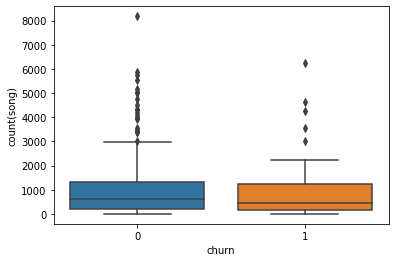

In [87]:
ax = sns.boxplot(x="churn", y="count(song)", data=df_count_song.toPandas())

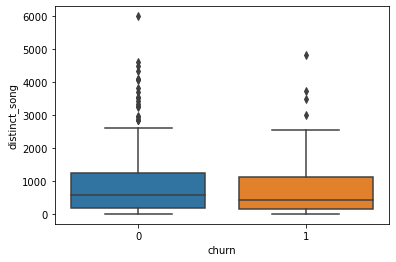

In [88]:
ax = sns.boxplot(x="churn", y="distinct_song", data=df_count_song.toPandas())

In [89]:
df_song_mean = df_count_song.groupby("churn").agg({"count(song)":"mean","distinct_song":"mean"})
df_song_mean.show(5)

+-----+-----------------+------------------+
|churn| avg(count(song))|avg(distinct_song)|
+-----+-----------------+------------------+
|    1|852.1111111111111| 756.6161616161617|
|    0|998.6189111747851| 879.3782234957021|
+-----+-----------------+------------------+



Churn users tend to play less songs on their usage.

### 12. userAgent Feature

In [90]:
df_user_agent = df.groupby(["userAgent","userId"]).agg({"churn":"mean"})
df_user_agent.show(5)

+--------------------+------+----------+
|           userAgent|userId|avg(churn)|
+--------------------+------+----------+
|Mozilla/5.0 (Wind...|   225|       0.0|
|"Mozilla/5.0 (Mac...|   293|       1.0|
|"Mozilla/5.0 (Win...|   197|       0.0|
|"Mozilla/5.0 (Win...|100048|       1.0|
|"Mozilla/5.0 (Win...|300040|       0.0|
+--------------------+------+----------+
only showing top 5 rows



In [91]:
df_user_agent_churn_rates = df_user_agent.groupby("userAgent").agg({"avg(churn)":"mean"})
df_user_agent_churn_rates.show(5)

+--------------------+------------------+
|           userAgent|   avg(avg(churn))|
+--------------------+------------------+
|"Mozilla/5.0 (Mac...|0.3333333333333333|
|"Mozilla/5.0 (Win...|               0.0|
|Mozilla/5.0 (X11;...|               0.0|
|"Mozilla/5.0 (Mac...|               0.2|
|"Mozilla/5.0 (Mac...|0.3333333333333333|
+--------------------+------------------+
only showing top 5 rows



It seems affecting the churn rate but this can be because of big number of userAgent types and our small dataset.

There are 71 agent types and 448 user. Effect of this feature may be missleading. 

High cardinality is especially a wrong risky factor for decision tree based algorithms since they tend to use whatever feature that splits trees more.

We will not use this feature because of these reasons.

In [92]:
user_agents = df.select("userAgent").dropDuplicates().collect()
user_agents_list =  [str(row.userAgent) for row in user_agents]
user_ids = df.select("userId").dropDuplicates().collect()
user_ids_list =  [str(row.userId) for row in user_ids]
print(len(user_agents_list))
print(len(user_ids_list))
user_agents_list[:5]

71
448


['"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"',
 '"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"',
 'Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0',
 '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"',
 '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"']

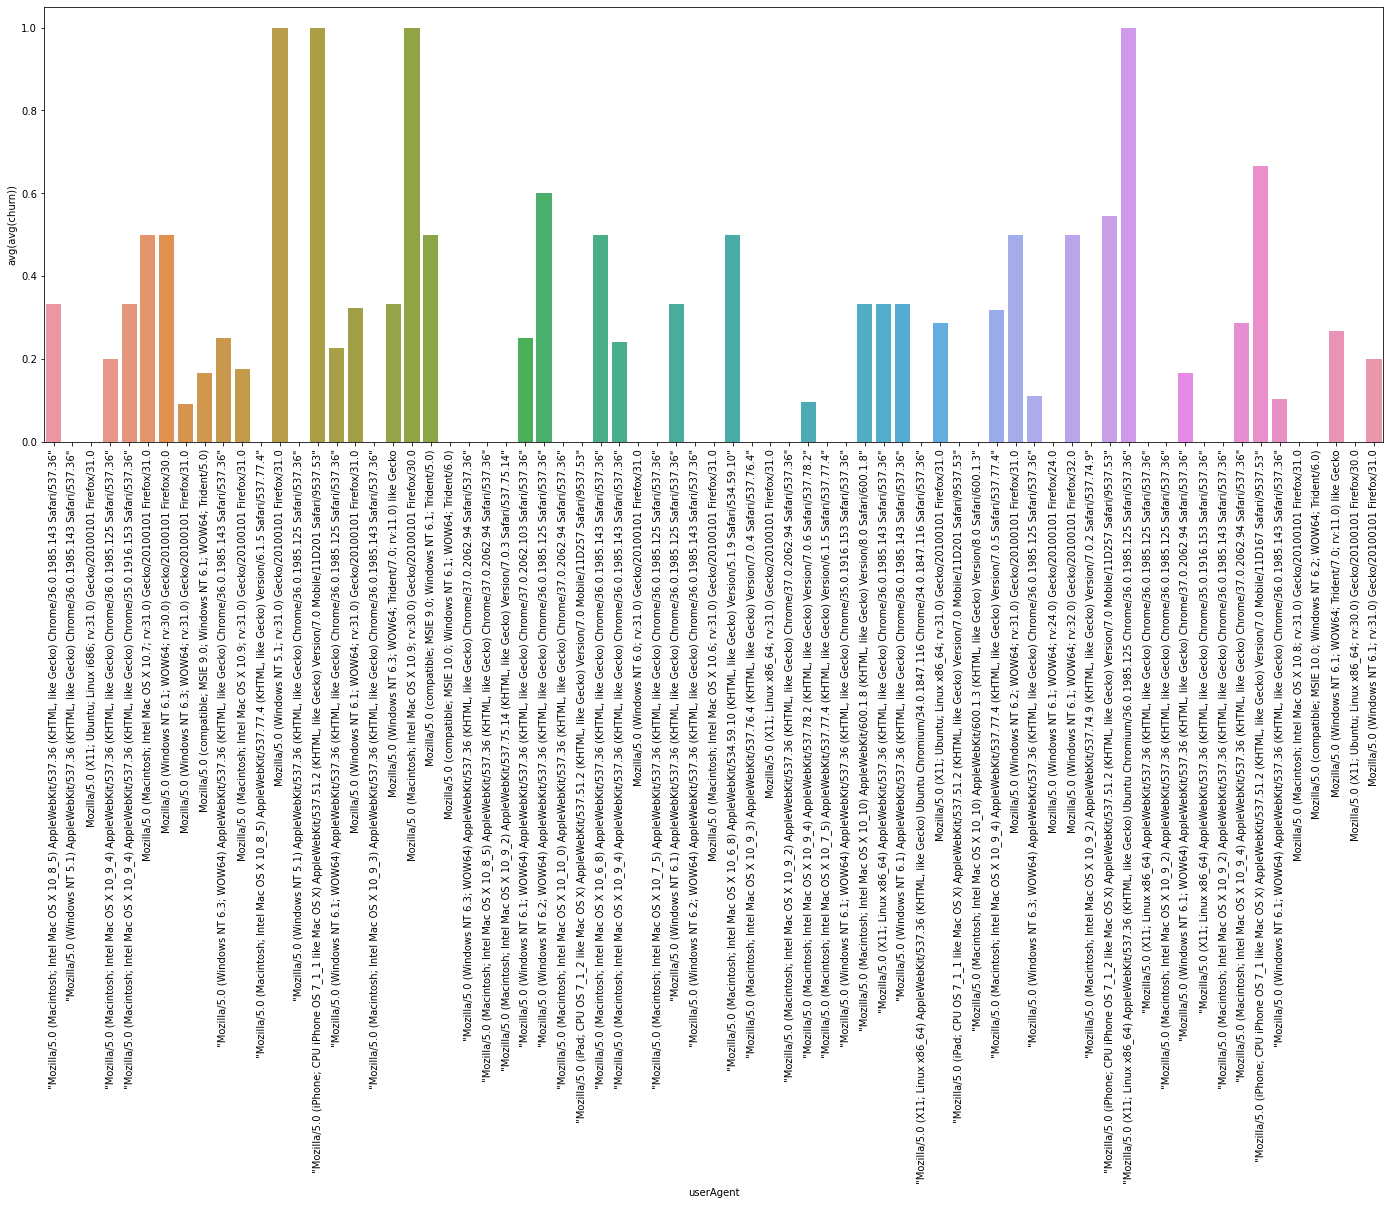

In [93]:
fig = plt.figure(figsize=(24, 8))
sns.barplot(x="userAgent", y="avg(avg(churn))", data=df_user_agent_churn_rates.toPandas())
plt.xticks(rotation=90)
plt.show()

In [94]:
df = df.drop("userAgent")

### 13. SessionId Feature

In [97]:
df_session_count = df.groupby(["userId","churn"]).agg(countDistinct("sessionId").alias("distinct_sessionId"))
df_session_count.show(5)

+------+-----+------------------+
|userId|churn|distinct_sessionId|
+------+-----+------------------+
|    19|    0|                 3|
|    73|    0|                13|
|   209|    0|                12|
|200007|    0|                 5|
|100030|    1|                 3|
+------+-----+------------------+
only showing top 5 rows



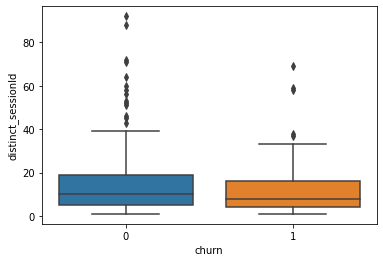

In [98]:
ax = sns.boxplot(x="churn", y="distinct_sessionId", data=df_session_count.toPandas())

In [99]:
df_session_count_churn_rate = df_session_count.groupby("churn").agg({"userId":"count","distinct_sessionId":"mean"})
df_session_count_churn_rate.show(5)

+-----+-----------------------+-------------+
|churn|avg(distinct_sessionId)|count(userId)|
+-----+-----------------------+-------------+
|    1|     12.090909090909092|           99|
|    0|     13.991404011461318|          349|
+-----+-----------------------+-------------+



Churn users seem to have less sessions, their mean is around 12. Non-churners average is 14.

### 14. Page Feature

In [100]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [101]:
df_page_pivot = df.groupby(["userId","churn"]).pivot("page").count()
df_page_pivot = df_page_pivot.drop("Cancel")
df_page_pivot = df_page_pivot.drop("Cancellation Confirmation")
df_page_pivot = df_page_pivot.fillna(0)
df_page_pivot.toPandas().head()

,userId,churn,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,73,0,0,4,5,0,1,2,16,5,240,20,0,2,0,0,1,9,2
1,19,0,0,1,4,0,0,0,1,0,51,2,0,0,0,0,0,3,0
2,100030,1,0,2,4,0,0,1,4,2,98,3,0,0,0,0,0,3,0
3,209,0,5,20,48,10,3,10,69,22,1499,0,2,10,1,1,12,59,1
4,100005,1,0,0,1,0,0,0,3,1,72,17,0,0,0,0,1,2,1


In [102]:
df_page_pivot.columns

['userId',
 'churn',
 'About',
 'Add Friend',
 'Add to Playlist',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Logout',
 'NextSong',
 'Roll Advert',
 'Save Settings',
 'Settings',
 'Submit Downgrade',
 'Submit Upgrade',
 'Thumbs Down',
 'Thumbs Up',
 'Upgrade']

   churn  avg(About)
0      1    1.868687
1      0    2.409742


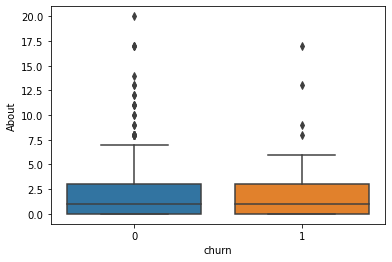

-----------------------------------------------------------------------------------------
   churn  avg(Add Friend)
0      1        15.525253
1      0        18.767908


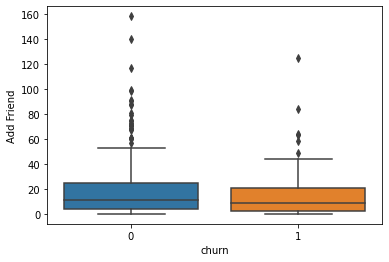

-----------------------------------------------------------------------------------------
   churn  avg(Add to Playlist)
0      1             22.818182
1      0             28.911175


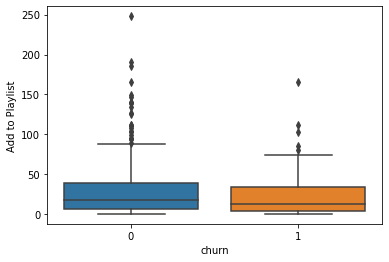

-----------------------------------------------------------------------------------------
   churn  avg(Downgrade)
0      1        8.393939
1      0        8.538682


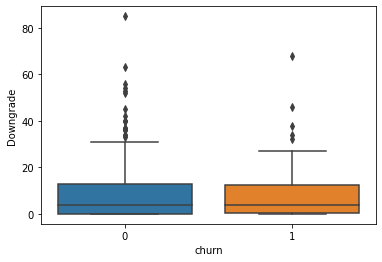

-----------------------------------------------------------------------------------------
   churn  avg(Error)
0      1    0.979798
1      0    1.163324


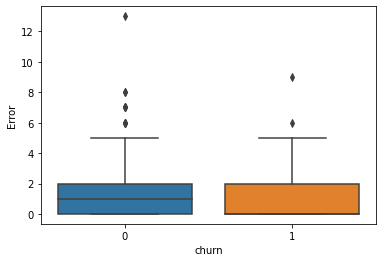

-----------------------------------------------------------------------------------------
   churn  avg(Help)
0      1   5.222222
1      0   6.094556


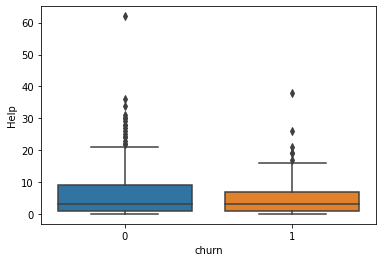

-----------------------------------------------------------------------------------------
   churn  avg(Home)
0      1  38.161616
1      0  43.871060


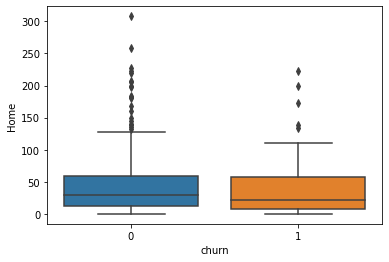

-----------------------------------------------------------------------------------------
   churn  avg(Logout)
0      1    11.959596
1      0    13.770774


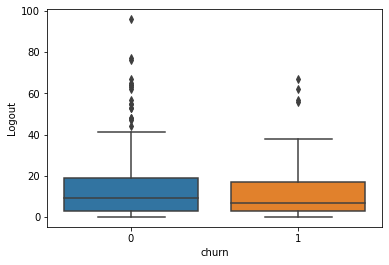

-----------------------------------------------------------------------------------------
   churn  avg(NextSong)
0      1     852.111111
1      0     998.618911


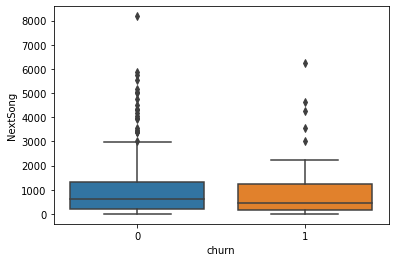

-----------------------------------------------------------------------------------------
   churn  avg(Roll Advert)
0      1         22.080808
1      0         16.008596


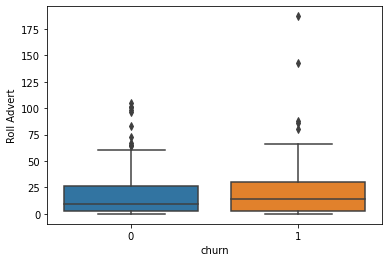

-----------------------------------------------------------------------------------------
   churn  avg(Save Settings)
0      1            1.050505
1      0            1.378223


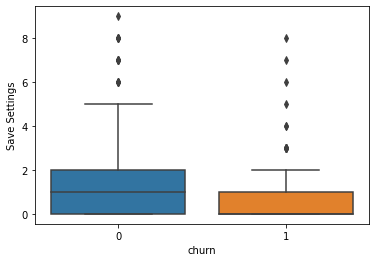

-----------------------------------------------------------------------------------------
   churn  avg(Settings)
0      1       6.252525
1      0       6.719198


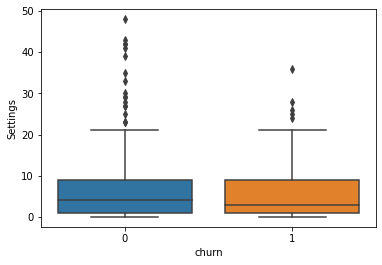

-----------------------------------------------------------------------------------------
   churn  avg(Submit Downgrade)
0      1               0.292929
1      0               0.252149


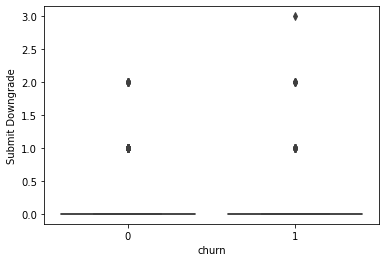

-----------------------------------------------------------------------------------------
   churn  avg(Submit Upgrade)
0      1             0.707071
1      0             0.621777


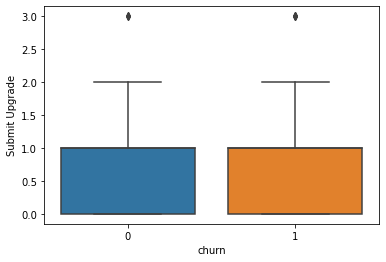

-----------------------------------------------------------------------------------------
   churn  avg(Thumbs Down)
0      1         11.676768
1      0         10.759312


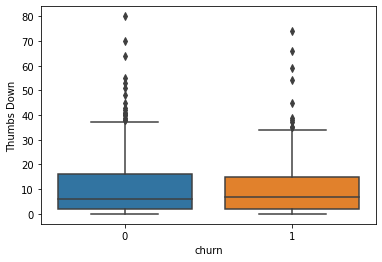

-----------------------------------------------------------------------------------------
   churn  avg(Thumbs Up)
0      1       43.434343
1      0       55.948424


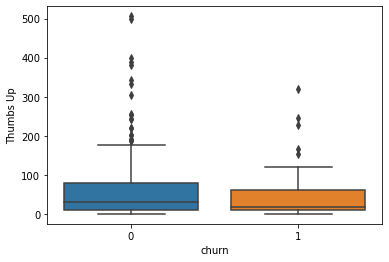

-----------------------------------------------------------------------------------------
   churn  avg(Upgrade)
0      1      2.393939
1      0      2.094556


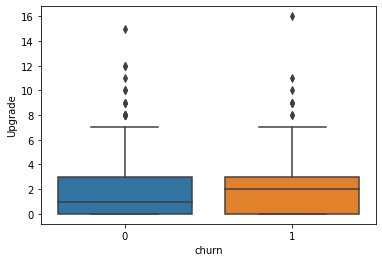

-----------------------------------------------------------------------------------------


In [103]:
column_list = [
 'About',
 'Add Friend',
 'Add to Playlist',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Logout',
 'NextSong',
 'Roll Advert',
 'Save Settings',
 'Settings',
 'Submit Downgrade',
 'Submit Upgrade',
 'Thumbs Down',
 'Thumbs Up',
 'Upgrade']

for column in column_list:
    print(df_page_pivot.select(["userId","churn",column]).groupby("churn").agg({column:"mean"}).toPandas().head(2))
    sns.boxplot(x="churn", y=column, data=df_page_pivot.select(["userId","churn",column]).toPandas())
    plt.show()
    print("-----------------------------------------------------------------------------------------")

From the box-plots above, we can state that :

- Churn people tend to add less friends.
- Churn people tend to add less songs to playlists.
- Churn people are less likely to click downgrade pages.
- Churn people are less likely to get an error
- Churn people are less likely to want a help
- Churn people are likely to get more roll-advert
- Churn people's giving thumbs up or down numbers lower, it seems they dont like the interaction with app.

We will make normalization for per user, since every user volume is different. It can be missleading for algorithm.

Adding friend, submitting downgrade and upgrade are solid numbers. So we exlude these from percentage formulas.

Cancellation confirmation and cancel is the churn actions, we exclude them too.

In [104]:
df_page_count = df.filter("page != 'Cancellation Confirmation' and page != 'Cancel' and page !='Add Friend' and \
   page != 'Submit Downgrade'and page != 'Submit Upgrade'").groupBy('userId').count().alias("count")
df_page_count.toPandas().head()

,userId,count
0,296,147
1,100010,132
2,200002,390
3,125,81
4,51,323


In [105]:
df_page_pivot = df_page_pivot.join(df_page_count,['userId'])
df_page_pivot = df_page_pivot.withColumnRenamed("count", "totalPageCount")
df_page_pivot.toPandas().head()

,userId,churn,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,totalPageCount
0,100010,1,0,3,1,0,0,0,3,1,96,22,0,0,0,0,3,4,2,132
1,200002,1,1,2,6,3,0,1,23,11,310,11,0,2,0,1,5,15,2,390
2,296,1,0,2,3,1,0,2,7,3,112,9,0,1,0,1,0,8,1,147
3,125,0,0,3,2,0,0,2,2,0,62,6,0,3,0,0,1,3,0,81
4,124,1,3,26,45,21,0,10,70,17,1826,1,3,15,0,0,15,102,0,2128


In [106]:
for column in df_page_pivot.columns:
    if column not in ['userId', 'totalPageCount',"churn", 'Add Friend','Submit Downgrade','Submit Upgrade']:
        new_column_name = "freq" + column
        df_page_pivot = df_page_pivot.withColumn(new_column_name, df_page_pivot[column] / df_page_pivot['totalPageCount'])

In [107]:
df_page_pivot.toPandas().head()

,userId,churn,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,...,freqHelp,freqHome,freqLogout,freqNextSong,freqRoll Advert,freqSave Settings,freqSettings,freqThumbs Down,freqThumbs Up,freqUpgrade
0,100010,1,0,3,1,0,0,0,3,1,...,0.000000,0.022727,0.007576,0.727273,0.166667,0.00000,0.000000,0.022727,0.030303,0.015152
1,200002,1,1,2,6,3,0,1,23,11,...,0.002564,0.058974,0.028205,0.794872,0.028205,0.00000,0.005128,0.012821,0.038462,0.005128
2,296,1,0,2,3,1,0,2,7,3,...,0.013605,0.047619,0.020408,0.761905,0.061224,0.00000,0.006803,0.000000,0.054422,0.006803
3,125,0,0,3,2,0,0,2,2,0,...,0.024691,0.024691,0.000000,0.765432,0.074074,0.00000,0.037037,0.012346,0.037037,0.000000
4,124,1,3,26,45,21,0,10,70,17,...,0.004699,0.032895,0.007989,0.858083,0.000470,0.00141,0.007049,0.007049,0.047932,0.000000


In [108]:
df_page_pivot = df_page_pivot.select(['userId', "churn",
 'Add Friend',
 'Submit Downgrade',
 'Submit Upgrade',
 'freqAbout',
 'freqAdd to Playlist',
 'freqDowngrade',
 'freqError',
 'freqHelp',
 'freqHome',
 'freqLogout',
 'freqNextSong',
 'freqRoll Advert',
 'freqSave Settings',
 'freqSettings',
 'freqThumbs Down',
 'freqThumbs Up',
 'freqUpgrade'])
df_page_pivot.toPandas().head()

,userId,churn,Add Friend,Submit Downgrade,Submit Upgrade,freqAbout,freqAdd to Playlist,freqDowngrade,freqError,freqHelp,freqHome,freqLogout,freqNextSong,freqRoll Advert,freqSave Settings,freqSettings,freqThumbs Down,freqThumbs Up,freqUpgrade
0,100010,1,3,0,0,0.000000,0.007576,0.000000,0.0,0.000000,0.022727,0.007576,0.727273,0.166667,0.00000,0.000000,0.022727,0.030303,0.015152
1,200002,1,2,0,1,0.002564,0.015385,0.007692,0.0,0.002564,0.058974,0.028205,0.794872,0.028205,0.00000,0.005128,0.012821,0.038462,0.005128
2,296,1,2,0,1,0.000000,0.020408,0.006803,0.0,0.013605,0.047619,0.020408,0.761905,0.061224,0.00000,0.006803,0.000000,0.054422,0.006803
3,125,0,3,0,0,0.000000,0.024691,0.000000,0.0,0.024691,0.024691,0.000000,0.765432,0.074074,0.00000,0.037037,0.012346,0.037037,0.000000
4,124,1,26,0,0,0.001410,0.021147,0.009868,0.0,0.004699,0.032895,0.007989,0.858083,0.000470,0.00141,0.007049,0.007049,0.047932,0.000000


In [111]:
df_page_pivot.count()

448

#### Remove other useless features too

In [109]:
df = df.drop("status")

In [110]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- churn: integer (nullable = false)
 |-- register-datetime: string (nullable = true)



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.